# Data Exploration

In [1]:
# !pip install shapely
# !pip install geopandas
# !pip install contextily
# !conda install contextily --channel conda-forge
# !pip install geoplot
# !pip install eli5
# !pip install pdpbox
# !pip install shap
# !pip install rasterio
# !pip install --no-use-pep517 cartopy

In [2]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['Dates'])
test = pd.read_csv('data/test.csv', parse_dates=['Dates'], index_col='Id')

In [4]:
print('First date: ', str(train.Dates.describe()['first']))
print('Last date: ', str(train.Dates.describe()['last']))
print('Test data shape ', train.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Test data shape  (878049, 9)


In [5]:
train.head()

Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

#### Dates - timestamp of the crime incident
#### Category - category of the crime incident. (This is our target variable.)
#### Descript - detailed description of the crime incident
#### DayOfWeek - the day of the week
#### PdDistrict - the name of the Police Department District
#### Resolution - The resolution of the crime incident
#### Address - the approximate street address of the crime incident
#### X - Longitude
#### Y - Latitude

In [6]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

The dataset contains a lot of 'object' variables (aka strings) that we will need to encode

In [7]:
train.duplicated().sum()

2323

It also contains 2323 duplicates that we should remove.
We will also evaluate the position of the data points using the coordinates.

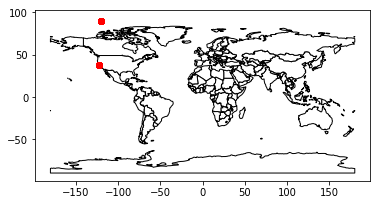

In [8]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

Some points are misplaced. Let's see how many they are.

In [9]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


Dates               Category  \
756059 2004-08-19 03:43:00         OTHER OFFENSES   
788574 2004-03-17 01:16:00     DISORDERLY CONDUCT   
852880 2003-05-02 01:00:00  SEX OFFENSES FORCIBLE   
759397 2004-08-03 19:30:00          LARCENY/THEFT   
798834 2004-01-24 14:00:00          LARCENY/THEFT   

                                     Descript  DayOfWeek PdDistrict  \
756059  DRIVERS LICENSE, SUSPENDED OR REVOKED   Thursday    BAYVIEW   
788574             COMMITTING PUBLIC NUISANCE  Wednesday   NORTHERN   
852880            FORCIBLE RAPE, BODILY FORCE     Friday   SOUTHERN   
759397           GRAND THEFT FROM LOCKED AUTO    Tuesday   NORTHERN   
798834                 GRAND THEFT PICKPOCKET   Saturday    CENTRAL   

                              Resolution  \
756059                     ARREST, CITED   
788574                    ARREST, BOOKED   
852880  COMPLAINANT REFUSES TO PROSECUTE   
759397                              NONE   
798834                              NONE   

                                        Address      X     Y  \
756059                  I-280 / PENNSYLVANIA AV -120.5  90.0   
788574                    LARKIN ST / AUSTIN ST -120.5  90.0   
852880           3RD ST / JAMES LICK FREEWAY HY -120.5  90.0   
759397                    LARKIN ST / AUSTIN ST -120.5  90.0   
798834  GREENWICH ST / THE EMBARCADERO NORTH ST -120.5  90.0   

              Coordinates  
756059  POINT (-120.5 90)  
788574  POINT (-120.5 90)  
852880  POINT (-120.5 90)  
759397  POINT (-120.5 90)  
798834  POINT (-120.5 90)

We will replace the outlying coordinates with the average coordinates of the district they belong.

In [10]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique() : 
    train.loc[train['PdDistrict']==district, ['X','Y']] = imp.fit_transform(train.loc[train['PdDistrict']==district, ['X','Y']])
    test.loc[test['PdDistrict']==district, ['X','Y']] = imp.fit_transform(test.loc[test['PdDistrict']==district, ['X','Y']])
    
train_gdf = create_gdf(train)

After cleaning the dataset from outliers and duplicates, we examine the variables.

#### Dates & Day of the week
These variables are distributed uniformly between 1/1/2003 to 5/13/2015 (and Monday to Sunday) and split between the training and the testing dataset as mentioned before. We did not notice any anomalies on these variables.
The median frequency of incidents is 389 per day with a standard deviation of 48.51.

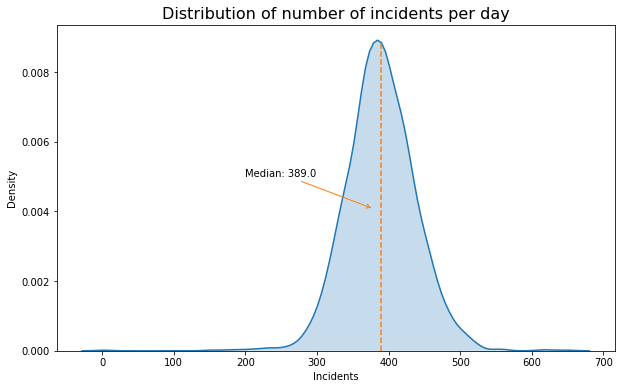

In [11]:
col = sns.color_palette()

train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour

plt.figure(figsize=(10,6))
data = train.groupby('Date').count().iloc[:,0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])

plt.annotate('Median: ' + str(data.median()), xy=(data.median(), 0.004), xytext=(200,0.005), arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))

plt.title('Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

Also, there is no significant deviation of incidents frequency throughout the week. Thus we do not expect this variable to play a significant role in the prediction.

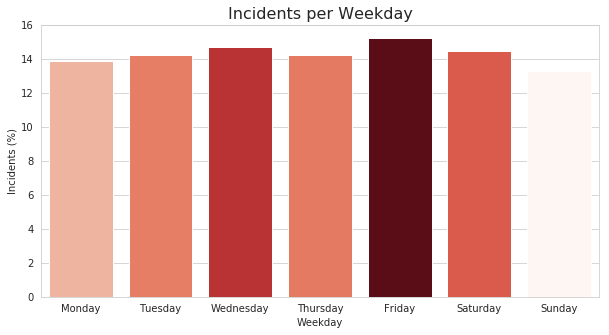

In [12]:
data = train.groupby('DayOfWeek').count().iloc[:,0]
data = data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10,5))
with sns.axes_style("whitegrid") : 
    ax = sns.barplot(data.index, (data.values/data.values.sum())*100, orient='v',
                    palette=cm.ScalarMappable(cmap='Reds').to_rgba(data.values))
    
plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')
plt.show()

#### Category
There are 39 discrete categories that the police department file the incidents with the most common being Larceny/Theft (19.91%), Non/Criminal (10.50%), and Assault(8.77%).

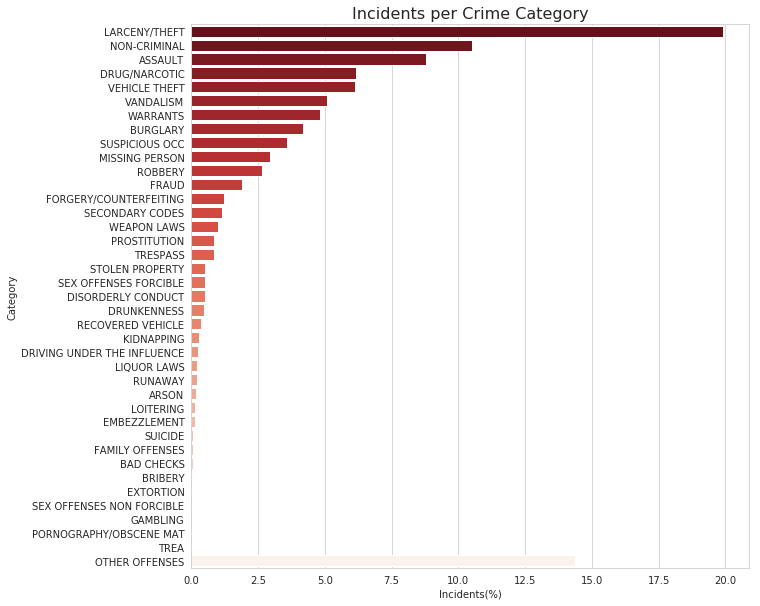

In [13]:
data = train.groupby('Category').count().iloc[:,0].sort_values(ascending=False)
data = data.reindex(np.append(np.delete(data.index,1), 'OTHER OFFENSES'))

plt.figure(figsize=(10,10))
with sns.axes_style("whitegrid") : 
    ax = sns.barplot((data.values/data.values.sum())*100, data.index, orient='h', palette="Reds_r")
    
plt.title('Incidents per Crime Category', fontdict={'fontsize':16})
plt.xlabel('Incidents(%)')
plt.show()

#### Police District
There are significant differences between the different districts of the City with the Southern district having the most incidents (17.87%) followed by Mission (13.67%) and Northern (12.00%).

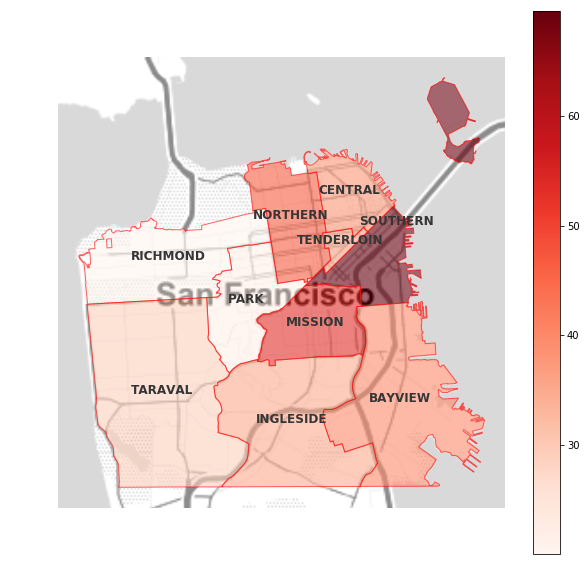

In [15]:
# Downloading the shapefile of the area 
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

#### Address
Address, as a text field, requires advanced techniques to use it for the prediction. Instead in this project, we will use it to extract if the incident has happened on the road or in a building block.

#### X - Longitude Y - Latitude
We have tested that the coordinates belong inside the boundaries of the city. Although longitude does not contain any outliers, latitude includes some 90o values which correspond to the North Pole.

### Exploratory Visualization
Based on the Projectâ€™s statement, we need to predict the probability of each type of crime based on time and location. That being said, we present two diagrams to visualize the importance of these variables. The first one presents the geographic density of 9 random crime categories. We can see that although the epicenter of most of the crimes resides on the northeast of the city, each crime has a different density on the rest of the city. This fact is a reliable indication that the location ( coordinates / Police District) will be a significant factor for the analysis and the forecasting.